## Section 1: Imports and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

df = pd.read_csv("../data/feature_engineered_monthly.csv")
df["year_month"] = pd.to_datetime(df["year_month"])

df = df[~df["state"].str.match(r"^\d+$", na=False)]

df = df[df["year_month"].notna()]

df["state"] = df["state"].str.strip().str.upper()

df["state"] = df["state"].str.replace(r"\s+", " ", regex=True)

df["state"] = df["state"].str.replace(r"^THE\s+", "", regex=True)



STATE_NORMALIZATION_MAP = {
    "JAMMU & KASHMIR": "JAMMU AND KASHMIR",
    
    # Andaman
    "ANDAMAN & NICOBAR ISLANDS": "ANDAMAN AND NICOBAR ISLANDS",

    # Dadra–Daman merger
    "DADRA AND NAGAR HAVELI": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DADRA & NAGAR HAVELI": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DAMAN & DIU": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DAMAN AND DIU": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DADRA & NAGAR HAVELI AND DAMAN & DIU": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
    "DADRA AND NAGAR HAVELI AND DAMAN AND DIU": "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",

    # West Bengal
    "WESTBENGAL": "WEST BENGAL",
    "WEST BANGAL": "WEST BENGAL",

    # Historical renames
    "ORISSA": "ODISHA",
    "PONDICHERRY": "PUDUCHERRY",
}


df["state"] = df["state"].replace(STATE_NORMALIZATION_MAP)
df["update_consistency"] = df["update_consistency"].fillna(0)

df["state"].value_counts().head(15)




state
DADRA AND NAGAR HAVELI AND DAMAN AND DIU    47
WEST BENGAL                                 26
PUDUCHERRY                                  24
ODISHA                                      24
JAMMU AND KASHMIR                           24
ANDAMAN AND NICOBAR ISLANDS                 21
CHHATTISGARH                                12
CHANDIGARH                                  12
UTTARAKHAND                                 12
UTTAR PRADESH                               12
TRIPURA                                     12
TELANGANA                                   12
TAMIL NADU                                  12
SIKKIM                                      12
RAJASTHAN                                   12
Name: count, dtype: int64

### Final sanity check

In [2]:
df["state"].value_counts()

state
DADRA AND NAGAR HAVELI AND DAMAN AND DIU    47
WEST BENGAL                                 26
PUDUCHERRY                                  24
ODISHA                                      24
JAMMU AND KASHMIR                           24
ANDAMAN AND NICOBAR ISLANDS                 21
CHHATTISGARH                                12
CHANDIGARH                                  12
UTTARAKHAND                                 12
UTTAR PRADESH                               12
TRIPURA                                     12
TELANGANA                                   12
TAMIL NADU                                  12
SIKKIM                                      12
RAJASTHAN                                   12
PUNJAB                                      12
ARUNACHAL PRADESH                           12
ASSAM                                       12
NAGALAND                                    12
MIZORAM                                     12
MEGHALAYA                                   12
MANIPUR

## Section 2: Baseline understanding

In [3]:
df["update_intensity"].describe()

count      526.000000
mean       278.664876
std       1464.527606
min          0.000000
25%         36.002377
50%         81.958503
75%        196.405321
max      29223.000000
Name: update_intensity, dtype: float64

## Section 3: Chart 1

### Prepare national aggregates

In [4]:
national = (
    df.groupby("year_month", as_index=False)
    .agg({
        "total_enrolment": "sum",
        "total_updates": "sum"
    })
)

### Plot

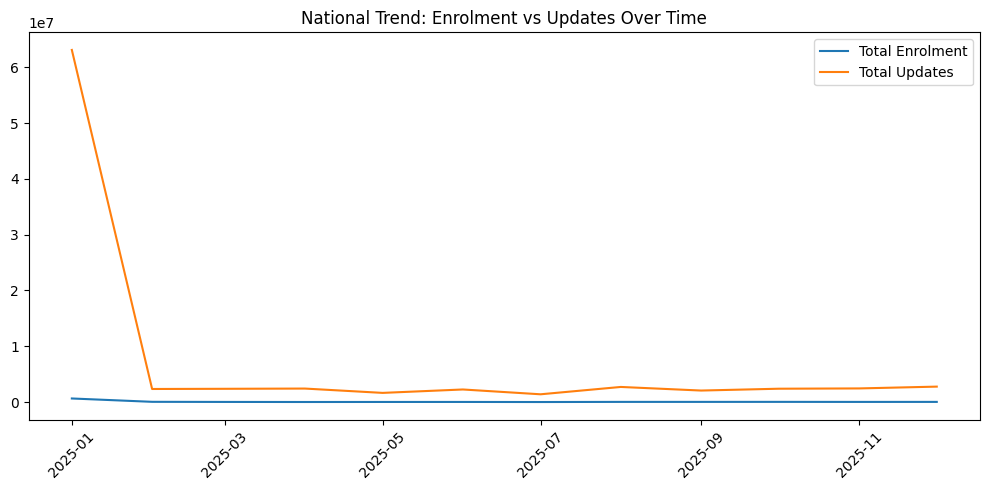

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(national["year_month"], national["total_enrolment"], label="Total Enrolment")
plt.plot(national["year_month"], national["total_updates"], label="Total Updates")
plt.xticks(rotation=45)
plt.title("National Trend: Enrolment vs Updates Over Time")
plt.legend()
plt.tight_layout()
plt.show()

## Section 4: Chart 2

### Prepare state averages

In [6]:
state_avg = (
    df.groupby("state", as_index=False)
    .agg({"update_intensity": "mean"})
    .sort_values("update_intensity")
)

### Plot

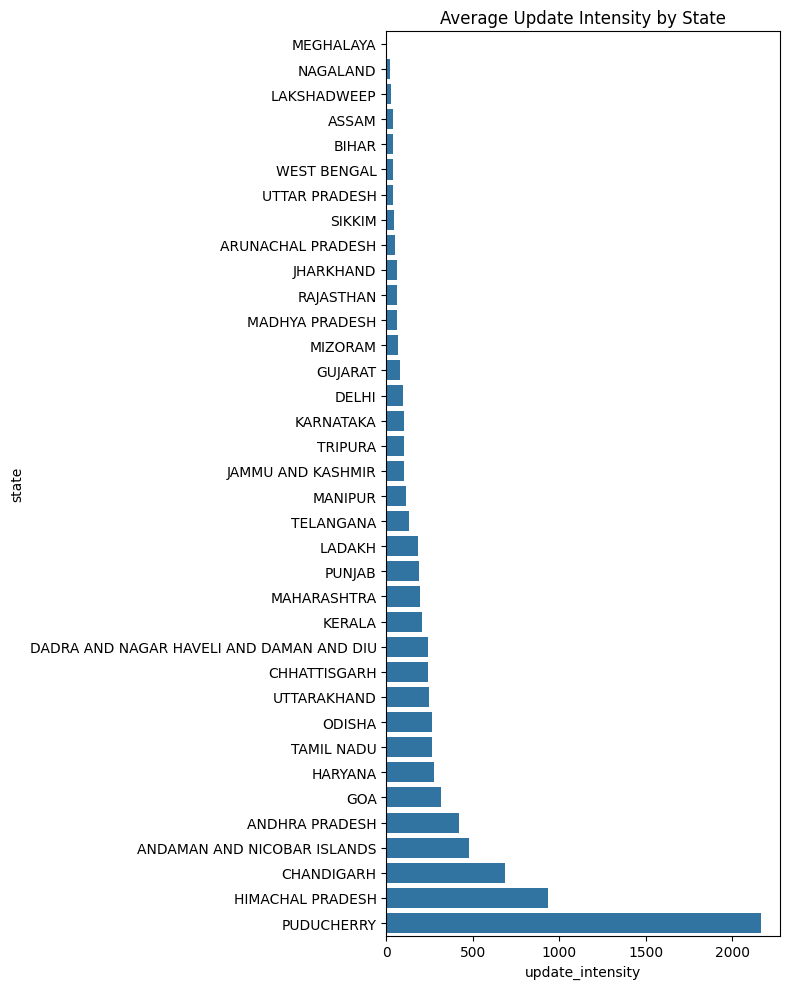

In [7]:
plt.figure(figsize=(8, 10))
sns.barplot(
    data=state_avg,
    y="state",
    x="update_intensity"
)
plt.title("Average Update Intensity by State")
plt.tight_layout()
plt.show()

## Section 5: Chart 3

### Age-group comparison of update ratios

In [8]:
age_compare = df[[
    "demo_ratio_5_17", "demo_ratio_18_plus",
    "bio_ratio_5_17", "bio_ratio_18_plus"
]].mean()

age_compare

demo_ratio_5_17         10.442054
demo_ratio_18_plus    1118.710127
bio_ratio_5_17          75.371548
bio_ratio_18_plus      731.511744
dtype: float64

### Plot

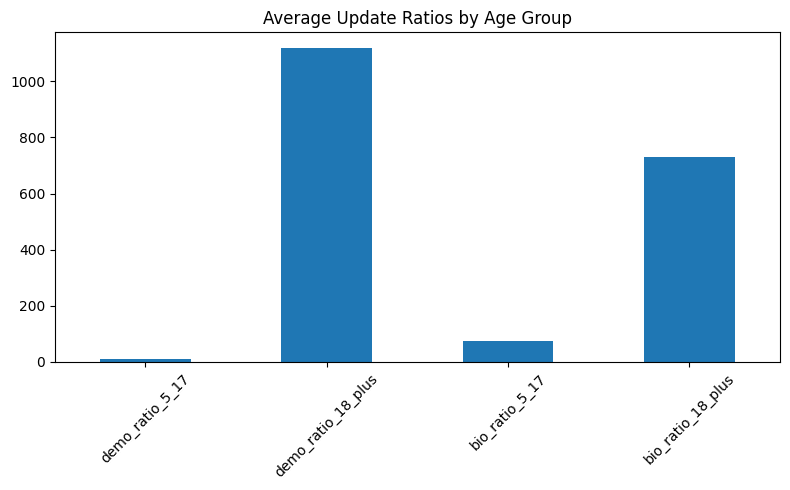

In [9]:
age_compare.plot(kind="bar", figsize=(8, 5))
plt.title("Average Update Ratios by Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Section 6: Chart 4

### Persistent low-update regions

In [10]:
low_update_states = (
    df.groupby("state")
    .filter(lambda x: x["year_month"].nunique() >= 4)
    .groupby("state")
    .agg(
        update_intensity=("update_intensity", "mean"),
        update_consistency=("update_consistency", "mean")
    )
    .sort_values("update_intensity")
    .head(10)
)

### Plot

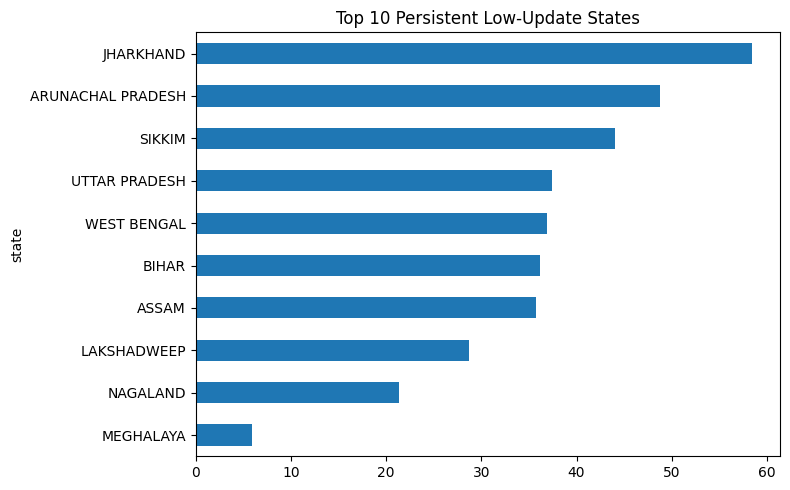

In [11]:
low_update_states["update_intensity"].plot(
    kind="barh", figsize=(8, 5)
)
plt.title("Top 10 Persistent Low-Update States")
plt.tight_layout()
plt.show()

In [12]:
df.groupby("state")["year_month"].nunique().sort_values(ascending=False).head(10)

state
ANDAMAN AND NICOBAR ISLANDS    12
ANDHRA PRADESH                 12
MAHARASHTRA                    12
MANIPUR                        12
MEGHALAYA                      12
MIZORAM                        12
NAGALAND                       12
ODISHA                         12
PUDUCHERRY                     12
PUNJAB                         12
Name: year_month, dtype: int64

## Section 7: Chart 5

### Update decay detection

In [13]:
valid_states = (
    df.groupby("state")
    .filter(
        lambda x: x["update_intensity"].sum() > 0
        and x["year_month"].nunique() >= 4
    )["state"]
    .unique()
)

valid_states[:10]

array(['ANDAMAN AND NICOBAR ISLANDS', 'ANDHRA PRADESH',
       'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHANDIGARH',
       'CHHATTISGARH', 'DADRA AND NAGAR HAVELI AND DAMAN AND DIU',
       'DELHI', 'GOA'], dtype=object)

In [14]:
candidate_states = (
    df.groupby("state")
    .filter(
        lambda x: x["update_intensity"].sum() > 0
        and x["year_month"].nunique() >= 4
    )
)

candidate_states["state"].value_counts().head()


state
DADRA AND NAGAR HAVELI AND DAMAN AND DIU    47
WEST BENGAL                                 26
PUDUCHERRY                                  24
ODISHA                                      24
JAMMU AND KASHMIR                           24
Name: count, dtype: int64

In [15]:
example_state = valid_states.tolist()[6]
example_state

'CHHATTISGARH'

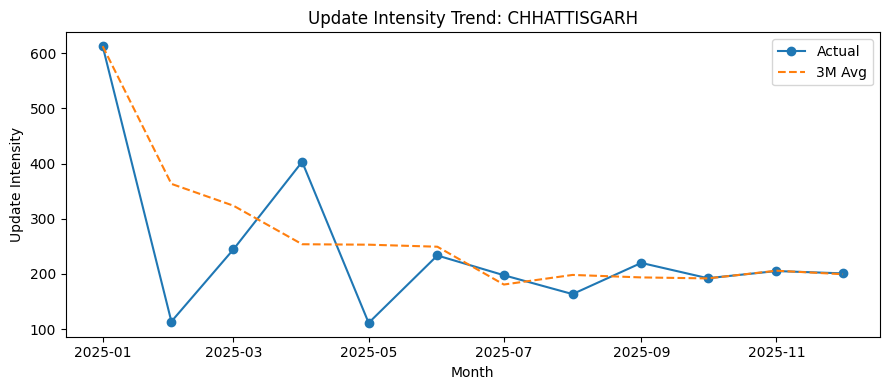

In [16]:
state_trend = (
    df[df["state"] == example_state]
    .sort_values("year_month")
)

plt.figure(figsize=(9, 4))

plt.plot(
    state_trend["year_month"],
    state_trend["update_intensity"],
    marker="o",
    label="Actual"
)

plt.plot(
    state_trend["year_month"],
    state_trend["update_intensity_3m_avg"],
    linestyle="--",
    label="3M Avg"
)

plt.title(f"Update Intensity Trend: {example_state}")
plt.xlabel("Month")
plt.ylabel("Update Intensity")
plt.legend()
plt.tight_layout()
plt.show()

### Final sanity check 

In [17]:
state_trend[[
    "year_month",
    "update_intensity",
    "update_intensity_3m_avg"
]]

,year_month,update_intensity,update_intensity_3m_avg
88,2025-01-01,612.578999,612.578999
89,2025-02-01,113.681643,363.130321
90,2025-03-01,244.430481,323.563708
91,2025-04-01,403.096154,253.736093
92,2025-05-01,111.253165,252.926600
93,2025-06-01,233.369748,249.239689
94,2025-07-01,197.610390,180.744434
95,2025-08-01,163.412214,198.130784
96,2025-09-01,219.908898,193.643834
97,2025-10-01,192.206501,191.842538


## Section 8: Chart 6

### Observed vs expected updates

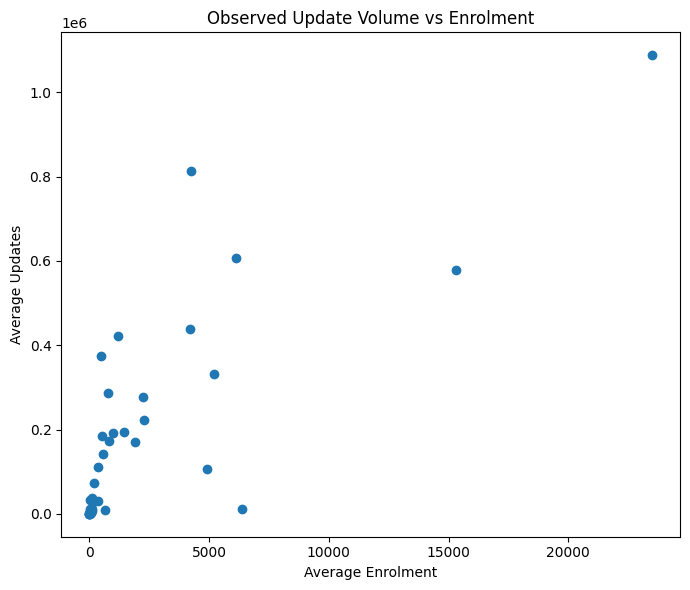

In [18]:
state_anomaly = (
    df.groupby("state", as_index=False)
    .agg({
        "total_enrolment": "mean",
        "total_updates": "mean"
    })
)

plt.figure(figsize=(7, 6))
plt.scatter(
    state_anomaly["total_enrolment"],
    state_anomaly["total_updates"]
)
plt.xlabel("Average Enrolment")
plt.ylabel("Average Updates")
plt.title("Observed Update Volume vs Enrolment")
plt.tight_layout()
plt.show()